# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv, header=0)
    df['label'] = df['label'].replace(['M', 'B'], [1, 0])
    df = df.sample(frac=1)
    X = df.iloc[:, 1:].to_numpy()
    y = df['label'].to_numpy()
    
    return X, y

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv, header=0)
    df = df.sample(frac=1)
    X = df.iloc[:, :-1].to_numpy()
    y = df['label'].to_numpy()
    
    return X, y

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.831e+01, 2.058e+01, 1.208e+02, ..., 1.510e-01, 3.074e-01,
         7.863e-02],
        [1.289e+01, 1.312e+01, 8.189e+01, ..., 5.366e-02, 2.309e-01,
         6.915e-02],
        [1.459e+01, 2.268e+01, 9.639e+01, ..., 1.105e-01, 2.258e-01,
         8.004e-02],
        ...,
        [1.146e+01, 1.816e+01, 7.359e+01, ..., 5.509e-02, 2.208e-01,
         7.638e-02],
        [1.308e+01, 1.571e+01, 8.563e+01, ..., 7.283e-02, 3.184e-01,
         8.183e-02],
        [9.777e+00, 1.699e+01, 6.250e+01, ..., 5.334e-02, 2.533e-01,
         8.468e-02]]),
 array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    # Не используем shuffle,так как сделали при чтении файла
    split_index = int(X.shape[0] * ratio)
    
    return X[:split_index], y[:split_index], X[split_index:], y[split_index:]

Для нормировки используем StandartScaler.

In [6]:
class StandartScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    
    def fit_transform(self, X_train):
        self.mean = X_train.mean(axis=0)
        self.std = X_train.std(axis=0)
        return (X_train - self.mean) / self.std
        
    def transform(self, X_test):
        return (X_test - self.mean) / self.std

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [7]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    
    # Считаем, что классы принимают значения от 0 до K. 
    N = len(y_true)
    classes = len(np.unique(list(y_pred) + list(y_true)))
    true_count, false_count, class_count = np.zeros(classes), np.zeros(classes), np.zeros(classes)

    for i in range(N):
        class_pred = y_pred[i]
        class_true = y_true[i]
        class_count[class_true] += 1
        
        if class_pred == class_true:
            true_count[class_pred] += 1
        else: 
            false_count[class_pred] += 1

    precisions = true_count / (true_count + false_count)
    recalls = true_count / class_count
    accuracy = true_count.sum() / N
    
    return precisions, recalls, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [8]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)     
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [9]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [10]:
class Node: 
    """ Базовый класс для узла дерева. """
        
    def _get_distance(self, point1: np.array, point2: np.array) -> float:
        """ Вычисление расстония между точками. """
        return np.linalg.norm(point1 - point2)
        
    def nearest_neighbors(self, point: np.array, k: int = 1) -> Tuple[np.array, np.array]:
        pass

In [12]:
class InnerNode(Node):
    """ Внутренний узел, хранит только параметры разделяющей гиперплоскости и ссылки на потомков. """
        
    def __init__(self, left, right, median: float, feature_index: int):
        self.left = left
        self.right = right
        self.median = median
        self.feature_index = feature_index
            
    def _merge(self, neighbors1: Tuple[np.array, np.array], 
               neighbors2: Tuple[np.array, np.array]) -> Tuple[np.array, np.array]:
        """ Слияние двух списков по расстояниям. """
        array1, dist1 = neighbors1
        array2, dist2 = neighbors2
        N, M = len(array1), len(array2)
        distances, indices = np.zeros(N + M), np.zeros(N + M, dtype=int)
        i, j = 0, 0

        for current_index in range(N + M):
            if i < N and j < M:
                if dist1[i] <= dist2[j]:
                    distances[current_index] = dist1[i]
                    indices[current_index] = array1[i]
                    i += 1
                else:
                    distances[current_index] = dist2[j]
                    indices[current_index] = array2[j]
                    j += 1
            else:
                if j >= M:
                    distances[current_index] = dist1[i]
                    indices[current_index] = array1[i]
                    i += 1
                else: 
                    distances[current_index] = dist2[j]
                    indices[current_index] = array2[j]
                    j += 1
            
        return indices, distances
            
    def _distance_to_hyperplance(self, point: np.array) -> float:
        """ Вычисление расстояния от точки до гиперплоскости. """
        return np.abs(point[self.feature_index] - self.median)
        
    def nearest_neighbors(self, point: np.array, k: int = 1) -> Tuple[np.array, np.array]:
        """ Поиск k ближайших соседей для конкретной точки вместе с расстояниями. """
            
        if point[self.feature_index] < self.median:
            # Посещаем левое поддерево
            nearest_neighbors, distances = self.left.nearest_neighbors(point, k)
            to_visit = self.right
        else:
            # Посещаем правое поддерево
            nearest_neighbors, distances = self.right.nearest_neighbors(point, k)
            to_visit = self.left
                
        highest_distance = distances[-1] # Расстояние до последнего соседа
            
        other_nearest_neighbors, other_distances = np.array([]), np.array([])
        if (highest_distance > self._distance_to_hyperplance(point)) or (len(nearest_neighbors) < k): 
            # Посещаем противоположное поддерево
            other_nearest_neighbors, other_distances = to_visit.nearest_neighbors(point, k)
                    
        merged_neighbors, merged_distances = self._merge((nearest_neighbors, distances), 
                                                         (other_nearest_neighbors, other_distances))
            
        return merged_neighbors[:k], merged_distances[:k] 

In [13]:
class LeafNode(Node):
    """ Лист дерева, хранит индексы элементов. """
        
    def __init__(self, X: np.array, indices: np.array):
        self.X = X
        self.indices = indices
            
    def nearest_neighbors(self, point: np.array, k: int = 1) -> Tuple[np.array, np.array]:
        """ Получение k ближайших соседей для точки point. """
        leaf_elements = self.X[self.indices]
        distances = np.apply_along_axis(lambda x: self._get_distance(point, x), 1, leaf_elements)
        sorted_k_indices = distances.argsort()[:k]
        neighbors = self.indices[sorted_k_indices]
        distances = distances[sorted_k_indices]
            
        return neighbors, distances

In [14]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """        
        self.X = X
        self.leaf_size = leaf_size
        n, m = X.shape
        self.m = m
        self.root = self._build_tree(np.arange(n), 0)


    def _build_tree(self, indices: np.array, feature_index: int) -> Node:
        if len(indices) < 2 * self.leaf_size:
            # Разделение невозможно, так как размер очень мал/
            return LeafNode(self.X, indices)

        data = self.X[indices]

        for _ in range(self.m):
            feature_values = data[:, feature_index]
            median = np.median(feature_values)
            
            # Индексы массива indeces с элементами меньше медианы и не меньше медианы
            less_indices = np.where(data[:, feature_index] < median)[0] 
            greater_indices = np.where(data[:, feature_index] >= median)[0]

            if len(less_indices) >= self.leaf_size and len(greater_indices) >= self.leaf_size:
                # Удалось хорошо разделить данные
                left = self._build_tree(indices[less_indices], (feature_index + 1) % self.m) 
                right = self._build_tree(indices[greater_indices], (feature_index + 1) % self.m)
                return InnerNode(left, right, median, feature_index)
            
            feature_index = (feature_index + 1) % self.m

            
        # Не удалось разделить ни по одному признаку
        return LeafNode(self.X, indices)

    
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        get_neighbours = lambda point: self.root.nearest_neighbors(point, k)[0]
        result = np.apply_along_axis(get_neighbours, 1, X)
        
        return result

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [15]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [16]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size  
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.X = X
        self.y = y
        self.kdtree = KDTree(X, self.leaf_size)
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
    
        classes_count = len(np.unique(self.y))
        kdtree_query = self.kdtree.query(X, self.n_neighbors)
        result = []
        
        for nearest_neighbors in kdtree_query:
            count = np.bincount(self.y[nearest_neighbors], minlength=classes_count)
            probas = count / self.n_neighbors
            result.append(probas)     
    
        return result
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

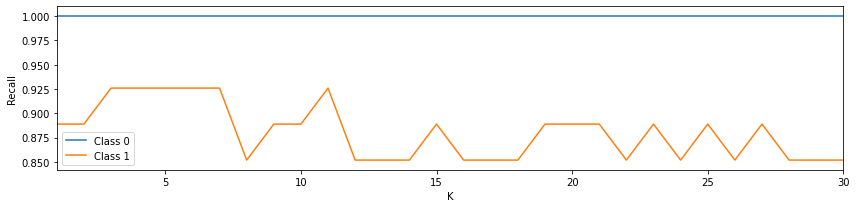

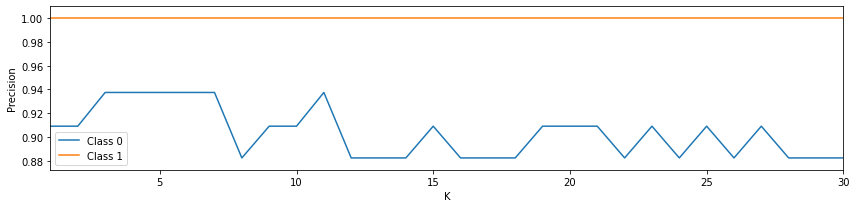

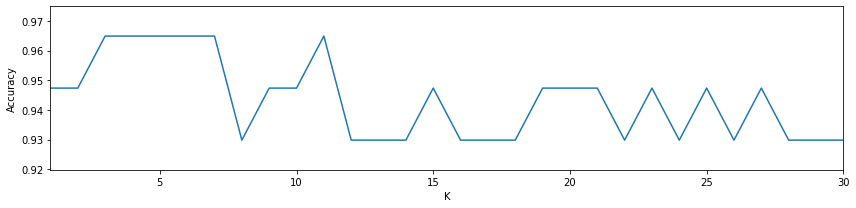

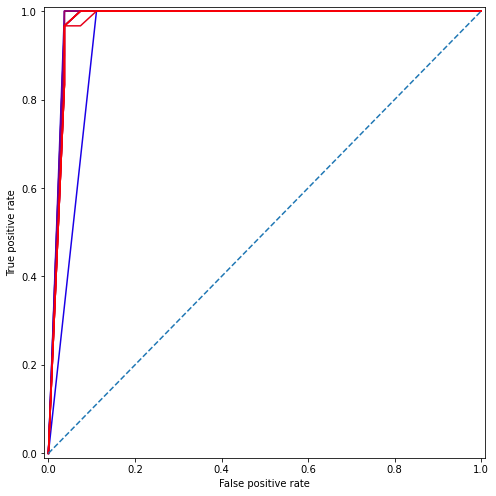

CPU times: user 19 s, sys: 440 ms, total: 19.4 s
Wall time: 18.6 s


In [18]:
%%time
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StandartScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

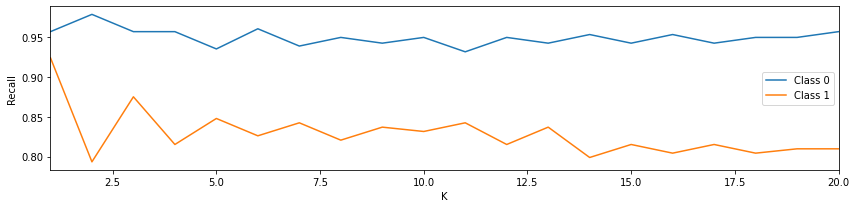

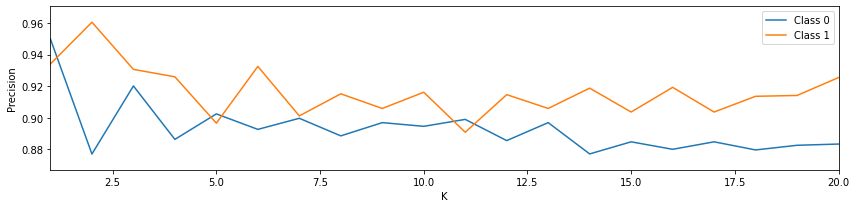

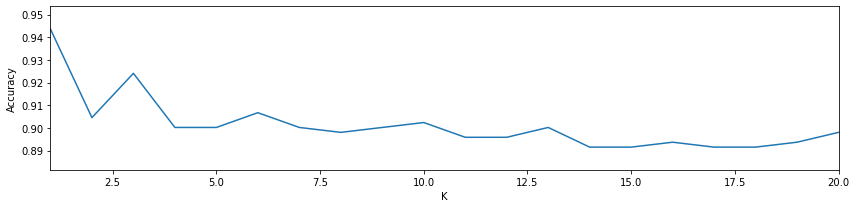

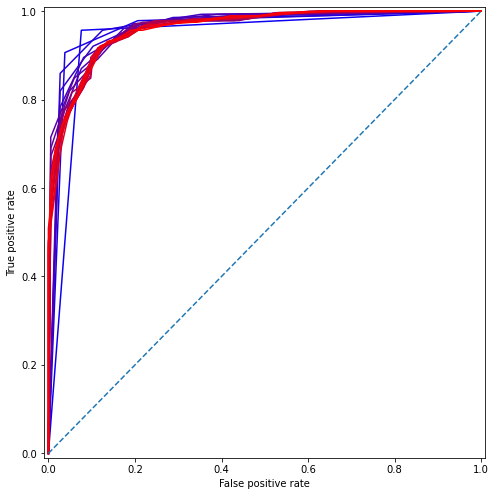

CPU times: user 15min 14s, sys: 619 ms, total: 15min 15s
Wall time: 15min 14s


In [19]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StandartScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)